In [1]:
library(cowplot)
source(file.path('~/link/res_publish','func_r_map_seurat.r'))
item = 'merge_B'
p_root_item = file.path('.')
p_plot_item = file.path(p_root_item,'fig')
if(!dir.exists(p_plot_item)){
    dir.create(p_plot_item,recursive = TRUE)
}

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.2 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching packag


> function----------------------------------------
serurat_to_mtx

> Map_Seurat function-----------------------------
Map_Seurat_normalize
Map_Seurat_cluster
Map_Seurat_mapquery
precess_after_Seurat
run_Seurat			[simply]

> other-------------------------------------------
get_path_varmap
show_
savefig
seurat_metadata_leftjoin
seurat_gene_detect


# Seurat 标准流程

In [2]:
file.exists(file.path(p_cache, "disease", "merge_mouse_kideny_healthy_SLE_imm_B"))

[1] TRUE

In [3]:
if (file.exists(file.path(p_root_item, sprintf("%s.rds", item)))) {
  cat(sprintf("[read] rds and markers\n"))
  adata <- readRDS(file.path(p_root_item, sprintf("%s.rds", item)))
  markers <- read_csv(file.path(p_root_item, sprintf("markers_%s.csv", item)))
} else {
  # 质控
  adata <- load_seuratobj(file.path(p_cache, "disease", "merge_mouse_kideny_healthy_SLE_imm_B"))
  adata@meta.data = adata@meta.data %>% select(
    cell_name,orig.ident,nCount_RNA,nFeature_RNA,X_batch,cell_type,status
)# %>% rename(pre_cell_type = cell_type)
  adata[["percent.mt"]] <- PercentageFeatureSet(adata, pattern = "^[Mm][Tt]-")
    # -------------------------
    # percent.mt_before.png
    # -------------------------
    ncol_ <- 3
    nrow_ <- 1
    options(repr.plot.width = 6 * ncol_, repr.plot.height = 6 * nrow_)
    p = VlnPlot(adata, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
    print(p)
    savefig(p,sprintf('%s_percent.mt_before.png',item),p_plot_item,
            width_ratio = ncol_ * 6, height_ratio = nrow_  * 6)
  # 标准流程
  adata@meta.data %>% head(2)
  options(repr.plot.width = 1 * 6, repr.plot.height = 1 * 6)
  adata <- Map_Seurat_normalize(adata)
  # function (adata, dims, resolution, key_batch, key_celltype = NULL, verbose = FALSE)
  options(repr.plot.width = 1 * 6, repr.plot.height = 1 * 6)
  adata <- Map_Seurat_cluster_run_harmony(
    adata, dims = 1:12, resolution = 0.2,
    key_batch = "X_batch")
  # marker
  adata@meta.data %>% head(2)
  markers <- FindAllMarkers(adata)
  markers %>% write_csv(file.path(p_root_item, sprintf("markers_%s.csv", item)))
  cat(sprintf("[out] %s\n", file.path(p_root_item, sprintf("markers_%s.csv", item))))
  saveRDS(adata, file.path(p_root_item, sprintf("%s.rds", item)))
  cat(sprintf("[out] %s\n", file.path(p_root_item, sprintf("%s.rds", item))))
}

markers <- markers %>% select(gene, cluster, avg_log2FC, pct.1, pct.2, p_val_adj) %>%
  filter(p_val_adj < 0.05, avg_log2FC > 1, pct.1 > 0.5) %>%
  arrange(cluster, desc(avg_log2FC)) %>% mutate(
    cluster = as.character(cluster)
  )
markers %>% head(2)

[read] rds and markers


Rows: 22780 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): gene
dbl (6): p_val, avg_log2FC, pct.1, pct.2, p_val_adj, cluster

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gene,cluster,avg_log2FC,pct.1,pct.2,p_val_adj
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Junb,0,1.112485,0.722,0.614,3.134963e-30
Jun,0,1.089346,0.697,0.541,3.853738e-30


In [4]:
adata@meta.data = adata@meta.data %>% mutate(
    seurat_clusters = as.character(seurat_clusters))
adata@meta.data %>% head(2)

,cell_name,orig.ident,nCount_RNA,nFeature_RNA,X_batch,cell_type,status,percent.mt,RNA_snn_res.0.2,seurat_clusters
,<chr>,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>
AACTCCCGTGTCGCTG-1;healthy,AACTCCCGTGTCGCTG-1;healthy,SeuratProject,1069,552,lost_7_batches,B cell,healthy,9.541628,2,2
AACTGGTTCGGCTTGG-1;healthy,AACTGGTTCGGCTTGG-1;healthy,SeuratProject,3979,1326,lost_7_batches,B cell,healthy,5.001257,4,4


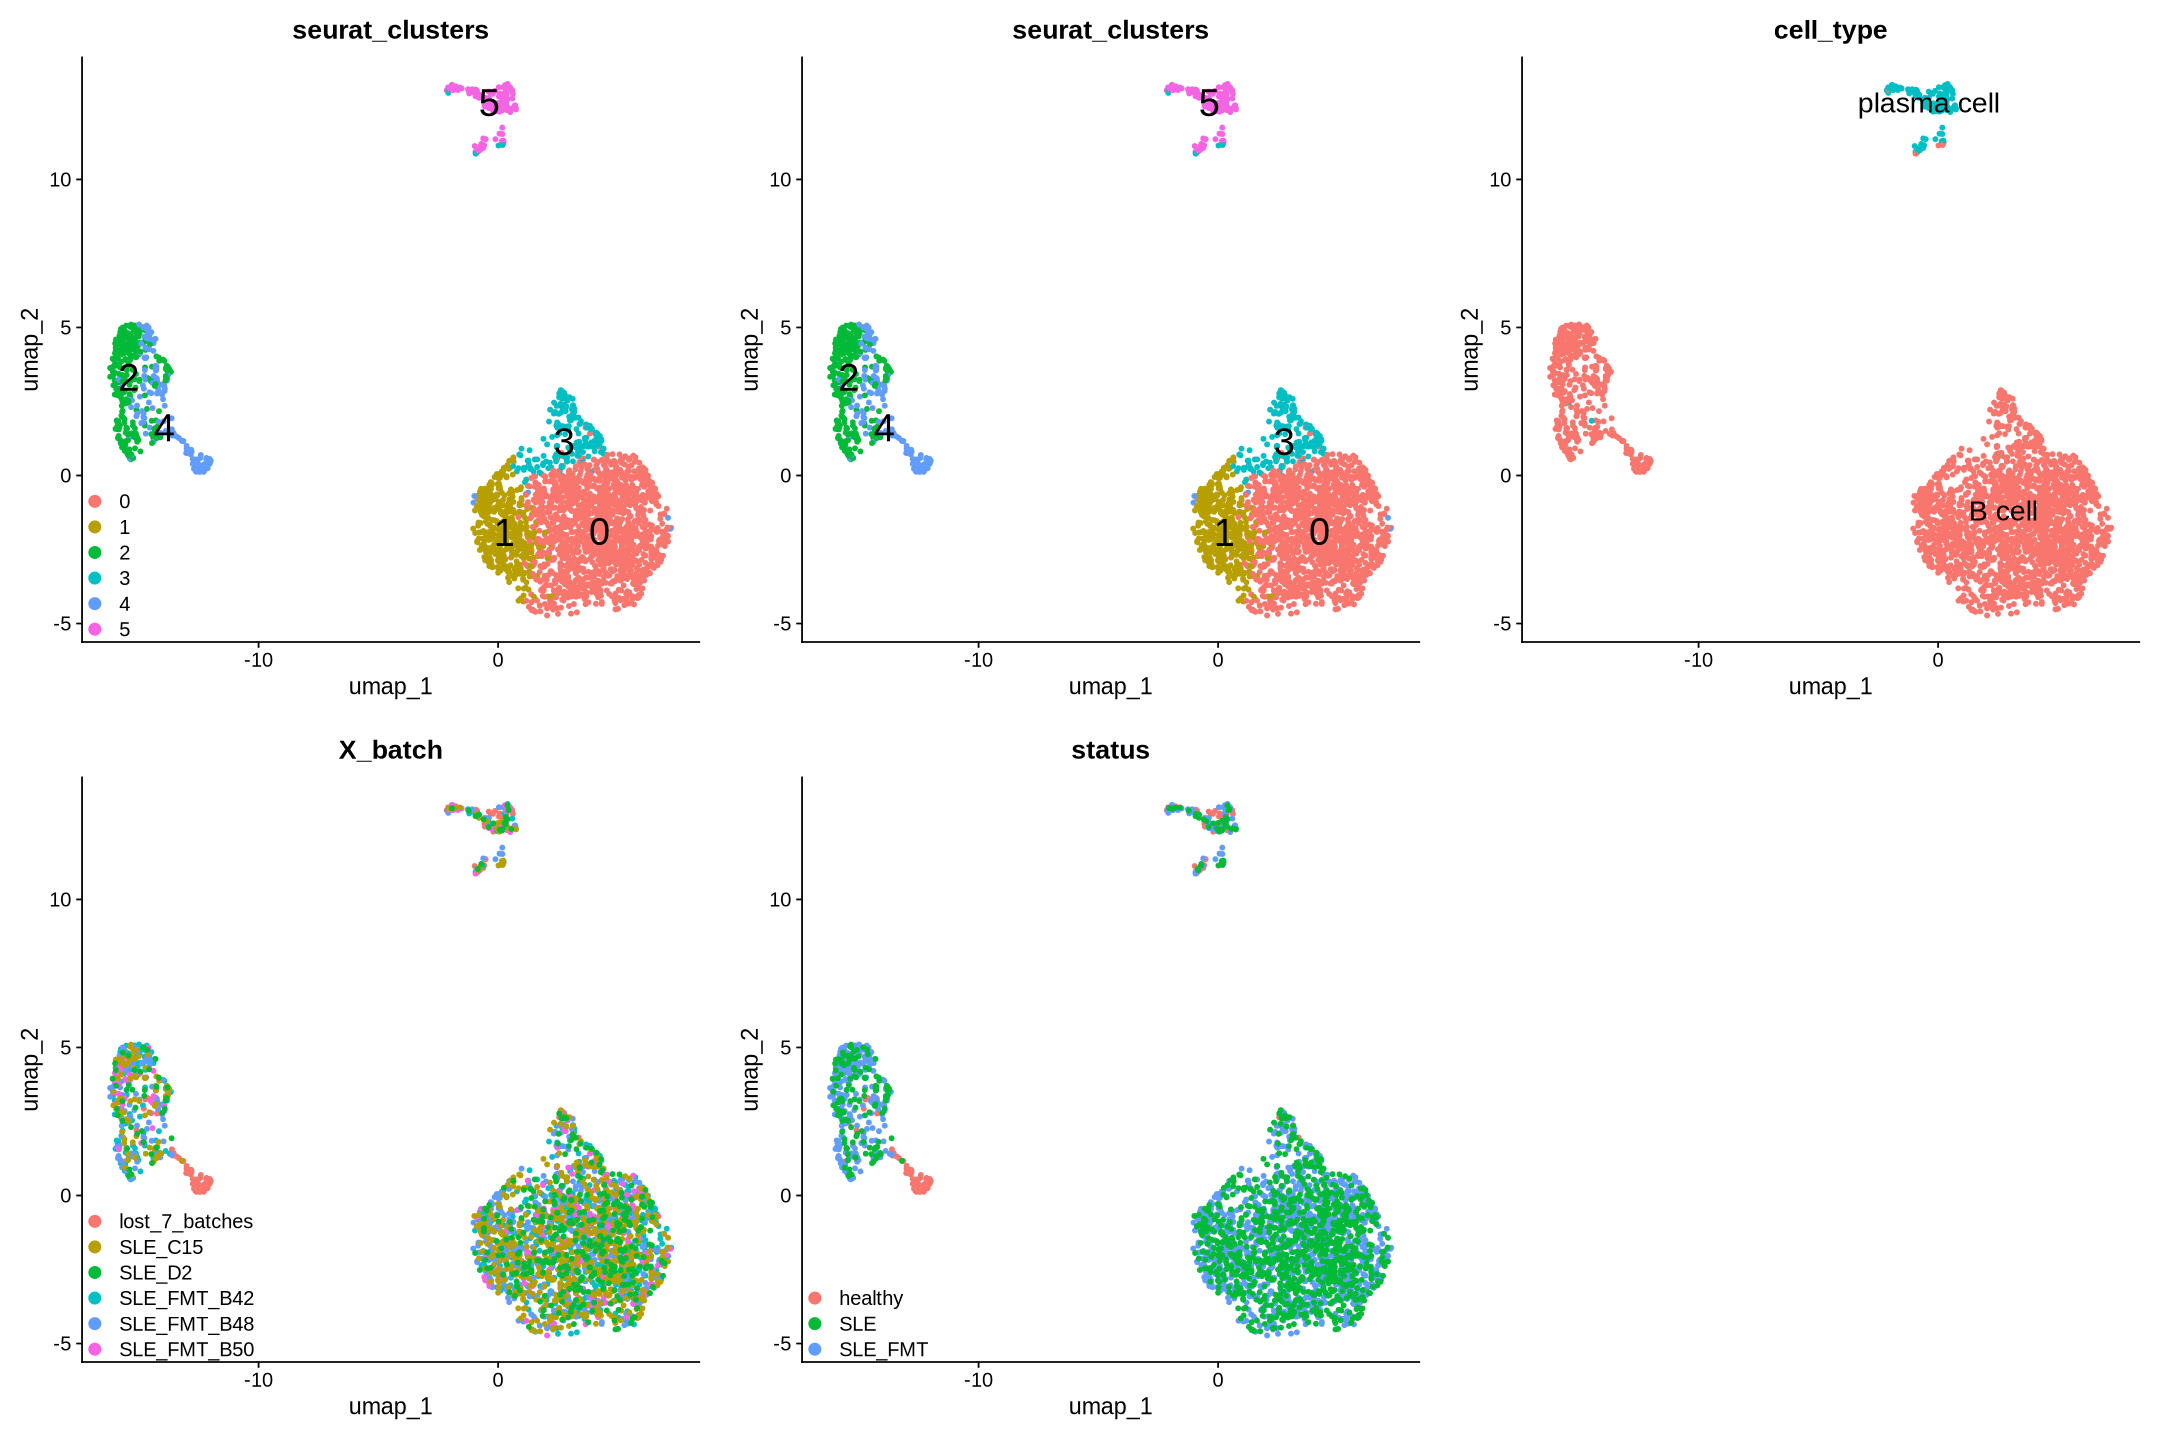

In [5]:
# --------------------------------------------------
# umap_cluster_before
# --------------------------------------------------
adata = FindClusters(adata,resolution = 0.4,verbose = FALSE)
nrow_ <- 2
ncol_ <- 3
options(repr.plot.width = ncol_ * 6, repr.plot.height = nrow_ * 6)
p1 <- UMAPPlot(adata, group.by = "seurat_clusters", label = TRUE, label.size =8,
  pt.size = 1) + them_legend
p2 <- UMAPPlot(adata, group.by = "seurat_clusters", label = TRUE, label.size = 8,
  pt.size = 1) + theme(legend.position = "none") #+ them_legend
p3 <- UMAPPlot(adata, group.by = "cell_type", label = TRUE, label.size = 6,
  pt.size = 1) + theme(legend.position = "none") #+ them_legend
p4 <- UMAPPlot(adata, group.by = "X_batch", pt.size = 1) + them_legend
p5 <- UMAPPlot(adata, group.by = "status", pt.size = 1) + them_legend
p <- cowplot::plot_grid(p1, p2, p3, p4, p5, nrow = nrow_, ncol = ncol_)
p

|||
|:-|:-|
|Endo|含有Henle的内皮，血管和降环|
|Podo|足细胞|
|PT|近端小管|
|LOH|Henle的升环|
|DCT|远端卷曲小管|
|CD-PC|集合管主细胞|
|CD-IC|CD插层细胞|
|CD-TRANS|CD过渡细胞|
|Fib|成纤维细胞|
|Novel1,Novel2|新细胞1,2|
|Macro|巨噬细胞|
|Neutro|中性粒细胞|
|NK|自然杀伤细胞|
|B lymph,T lymph|T,B细胞|

In [6]:
adata@meta.data %>% head(2)
paste(adata@meta.data$cell_type %>% unique,collapse = ',')

,cell_name,orig.ident,nCount_RNA,nFeature_RNA,X_batch,cell_type,status,percent.mt,RNA_snn_res.0.2,seurat_clusters,RNA_snn_res.0.4
,<chr>,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>
AACTCCCGTGTCGCTG-1;healthy,AACTCCCGTGTCGCTG-1;healthy,SeuratProject,1069,552,lost_7_batches,B cell,healthy,9.541628,2,4,4
AACTGGTTCGGCTTGG-1;healthy,AACTGGTTCGGCTTGG-1;healthy,SeuratProject,3979,1326,lost_7_batches,B cell,healthy,5.001257,4,3,3


[1] "B cell,plasma cell"

# query cluster

In [7]:
adata@meta.data %>% select(
    cell_name,orig.ident,X_batch,status,seurat_clusters
) %>% head(2)

,cell_name,orig.ident,X_batch,status,seurat_clusters
,<chr>,<fct>,<chr>,<chr>,<fct>
AACTCCCGTGTCGCTG-1;healthy,AACTCCCGTGTCGCTG-1;healthy,SeuratProject,lost_7_batches,healthy,4
AACTGGTTCGGCTTGG-1;healthy,AACTGGTTCGGCTTGG-1;healthy,SeuratProject,lost_7_batches,healthy,3


,cell_name,orig.ident,X_batch,status,seurat_clusters,cell_type,sub_cell_type
,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
AACTCCCGTGTCGCTG-1;healthy,AACTCCCGTGTCGCTG-1;healthy,SeuratProject,lost_7_batches,healthy,4,B cell,B unknow 2
AACTGGTTCGGCTTGG-1;healthy,AACTGGTTCGGCTTGG-1;healthy,SeuratProject,lost_7_batches,healthy,3,B cell,B unknow 1


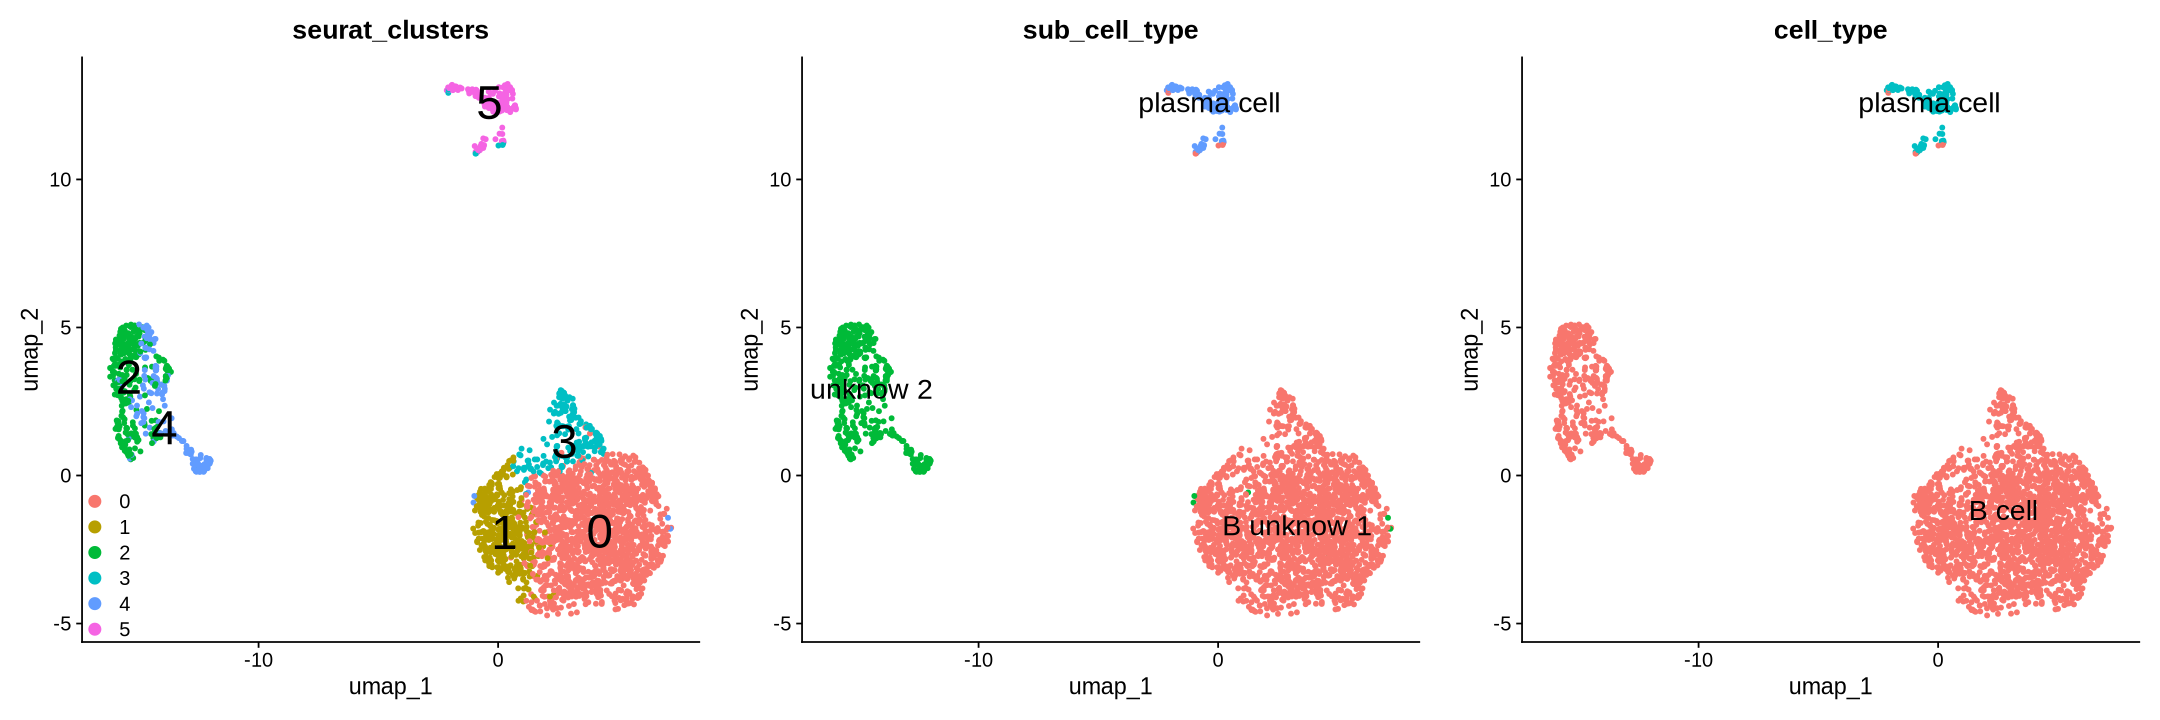

In [8]:
tbl_cell_type <- tribble(
  ~seurat_clusters,~cell_type,~sub_cell_type,
    '0','B cell','B unknow 1',
    '1','B cell','B unknow 1',
    '2','B cell','B unknow 2',
    '3','B cell','B unknow 1',
    '4','B cell','B unknow 2',
    '5','plasma cell','plasma cell',
)
adata@meta.data <- adata@meta.data %>%
  mutate(seurat_clusters = as.character(seurat_clusters))
adata@meta.data <- seurat_metadata_leftjoin(
  adata@meta.data %>% select(cell_name, orig.ident, X_batch,
    status, seurat_clusters),
  tbl_cell_type,
  by = c('seurat_clusters' = 'seurat_clusters'),
  key_cell_name = 'cell_name')
adata@meta.data %>% head(2)

ncol_ <- 3
nrow_ <- 1
options(repr.plot.width = 6 * ncol_, repr.plot.height = 6 * nrow_)
p1 <- UMAPPlot(adata, group.by = 'seurat_clusters', label = TRUE, label.size = 10,
  pt.size = 1) + them_legend
p2 <- UMAPPlot(adata, group.by = 'sub_cell_type', label = TRUE, label.size = 6,
  pt.size = 1) + theme(legend.position = 'none') # + them_legend
p3 <- UMAPPlot(adata, group.by = 'cell_type', label = TRUE, label.size = 6,
  pt.size = 1) + theme(legend.position = 'none') # + them_legend
p_temp <- cowplot::plot_grid(p1, p2, p3, nrow = nrow_, ncol = ncol_)
p_temp

## query sub cell type of T cell

In [9]:
tbl_marker <- bind_rows(
  tibble(
    'sub_cell_type' = 'cells',
      # Cd45由Ptprc编码
    'gene' = str_split('Ptprc,Cd3d,Cd19,Cd79a,Epcam', ',')[[1]]
),tibble(
    'sub_cell_type' = 'B cell',
    'gene' = str_split('Cd19,Cd40,Cd79a,Cd79b,Cd27', ',')[[1]]
),tibble(
    'sub_cell_type' = 'IFN',
    'gene' = str_split('Stat1,Isg15,Isg20,Ifit1,Ifit3', ',')[[1]]
),tibble(
    'sub_cell_type' = 'naive B',# IGHD+ CD27-
    'gene' = str_split('Cd27,Jchain', ',')[[1]]
),tibble(
    'sub_cell_type' = 'plasma cell',
      # Cd138由Sdc1编码
    'gene' = str_split('Sdc1', ',')[[1]]
)
)
cat(sprintf('[sub_cell_type]--------------------\n'))
paste(unique(tbl_marker$sub_cell_type),collapse = ',')
seurat_gene_detect(adata,'Cd4')

[sub_cell_type]--------------------


[1] "cells,B cell,IFN,naive B,plasma cell"

,counts,data,scale.data,gene
,<lgl>,<lgl>,<lgl>,<chr>
Cd48,TRUE,TRUE,FALSE,Cd48
Cd46,TRUE,TRUE,FALSE,Cd46
Cd44,TRUE,TRUE,TRUE,Cd44
Cd40,TRUE,TRUE,FALSE,Cd40
Cd40lg,TRUE,TRUE,FALSE,Cd40lg
Cd4,TRUE,TRUE,TRUE,Cd4
Cd47,TRUE,TRUE,FALSE,Cd47


In [10]:
read_csv(get_path_varmap('human','mouse')) %>% 
    filter(`Gene name` == 'EpCAM')

Rows: 75046 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Gene name, Mouse gene name, Mouse homology type

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Gene name,Mouse gene name,Mouse homology type
<chr>,<chr>,<chr>


In [18]:
seurat_gene_detect(adata,'Cd27')

,counts,data,scale.data,gene
,<lgl>,<lgl>,<lgl>,<chr>
Cd27,TRUE,TRUE,FALSE,Cd27
Cd276,TRUE,TRUE,FALSE,Cd276
Cd274,TRUE,TRUE,TRUE,Cd274


[1] "Ptprc,Cd3d,Cd19,Cd79a,Epcam"

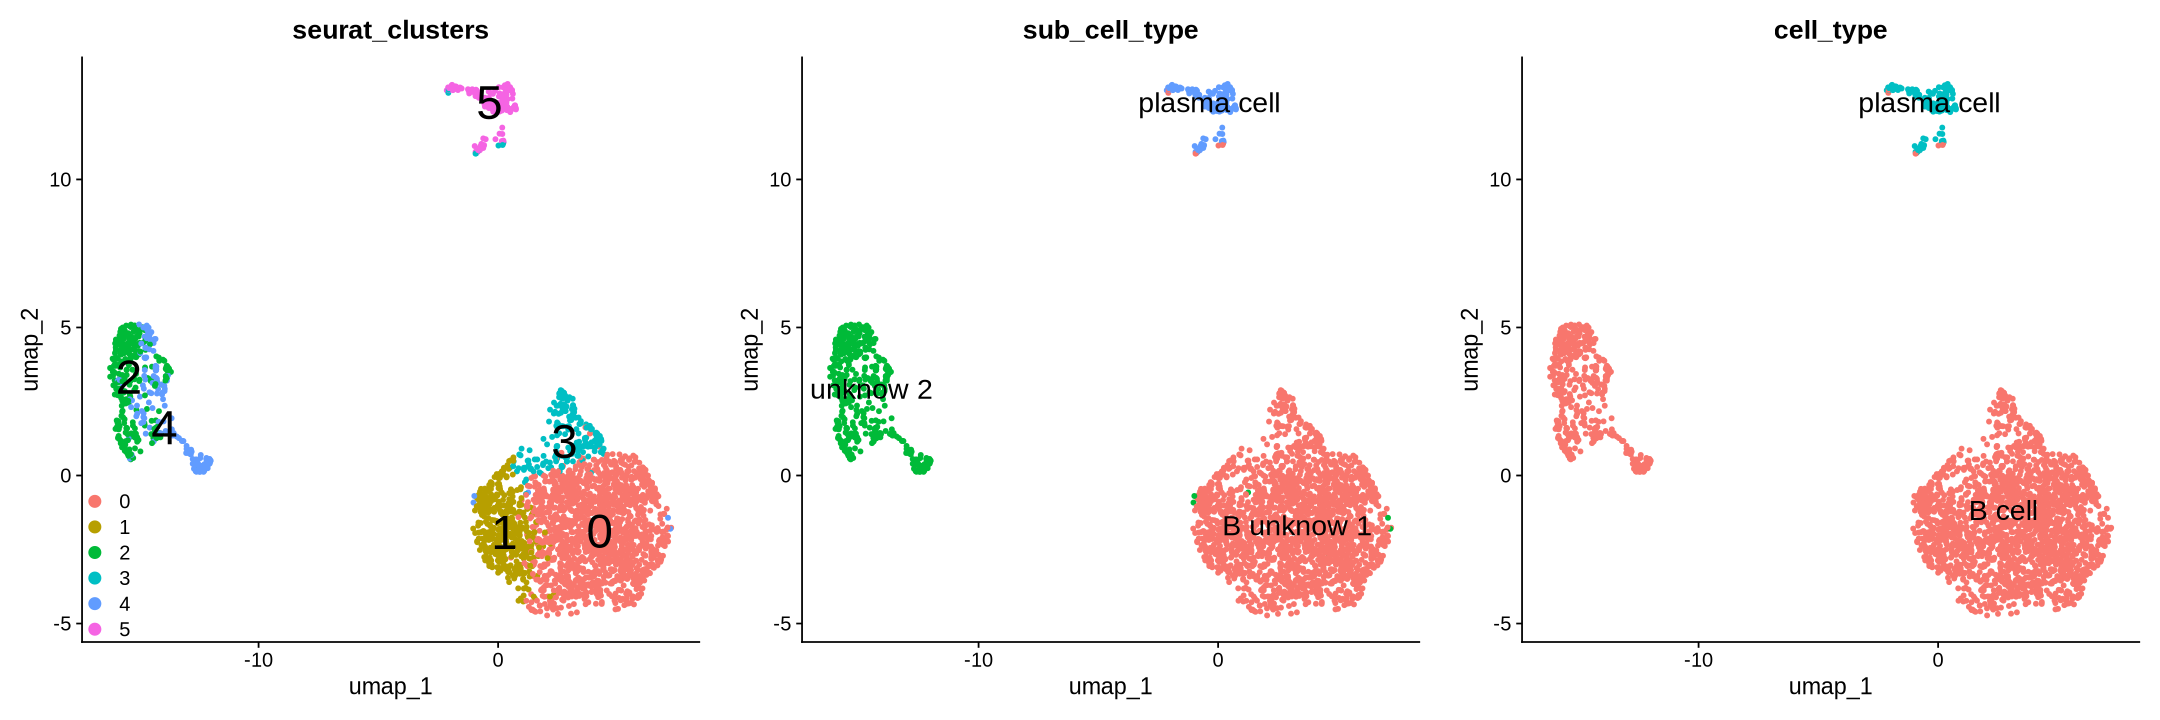

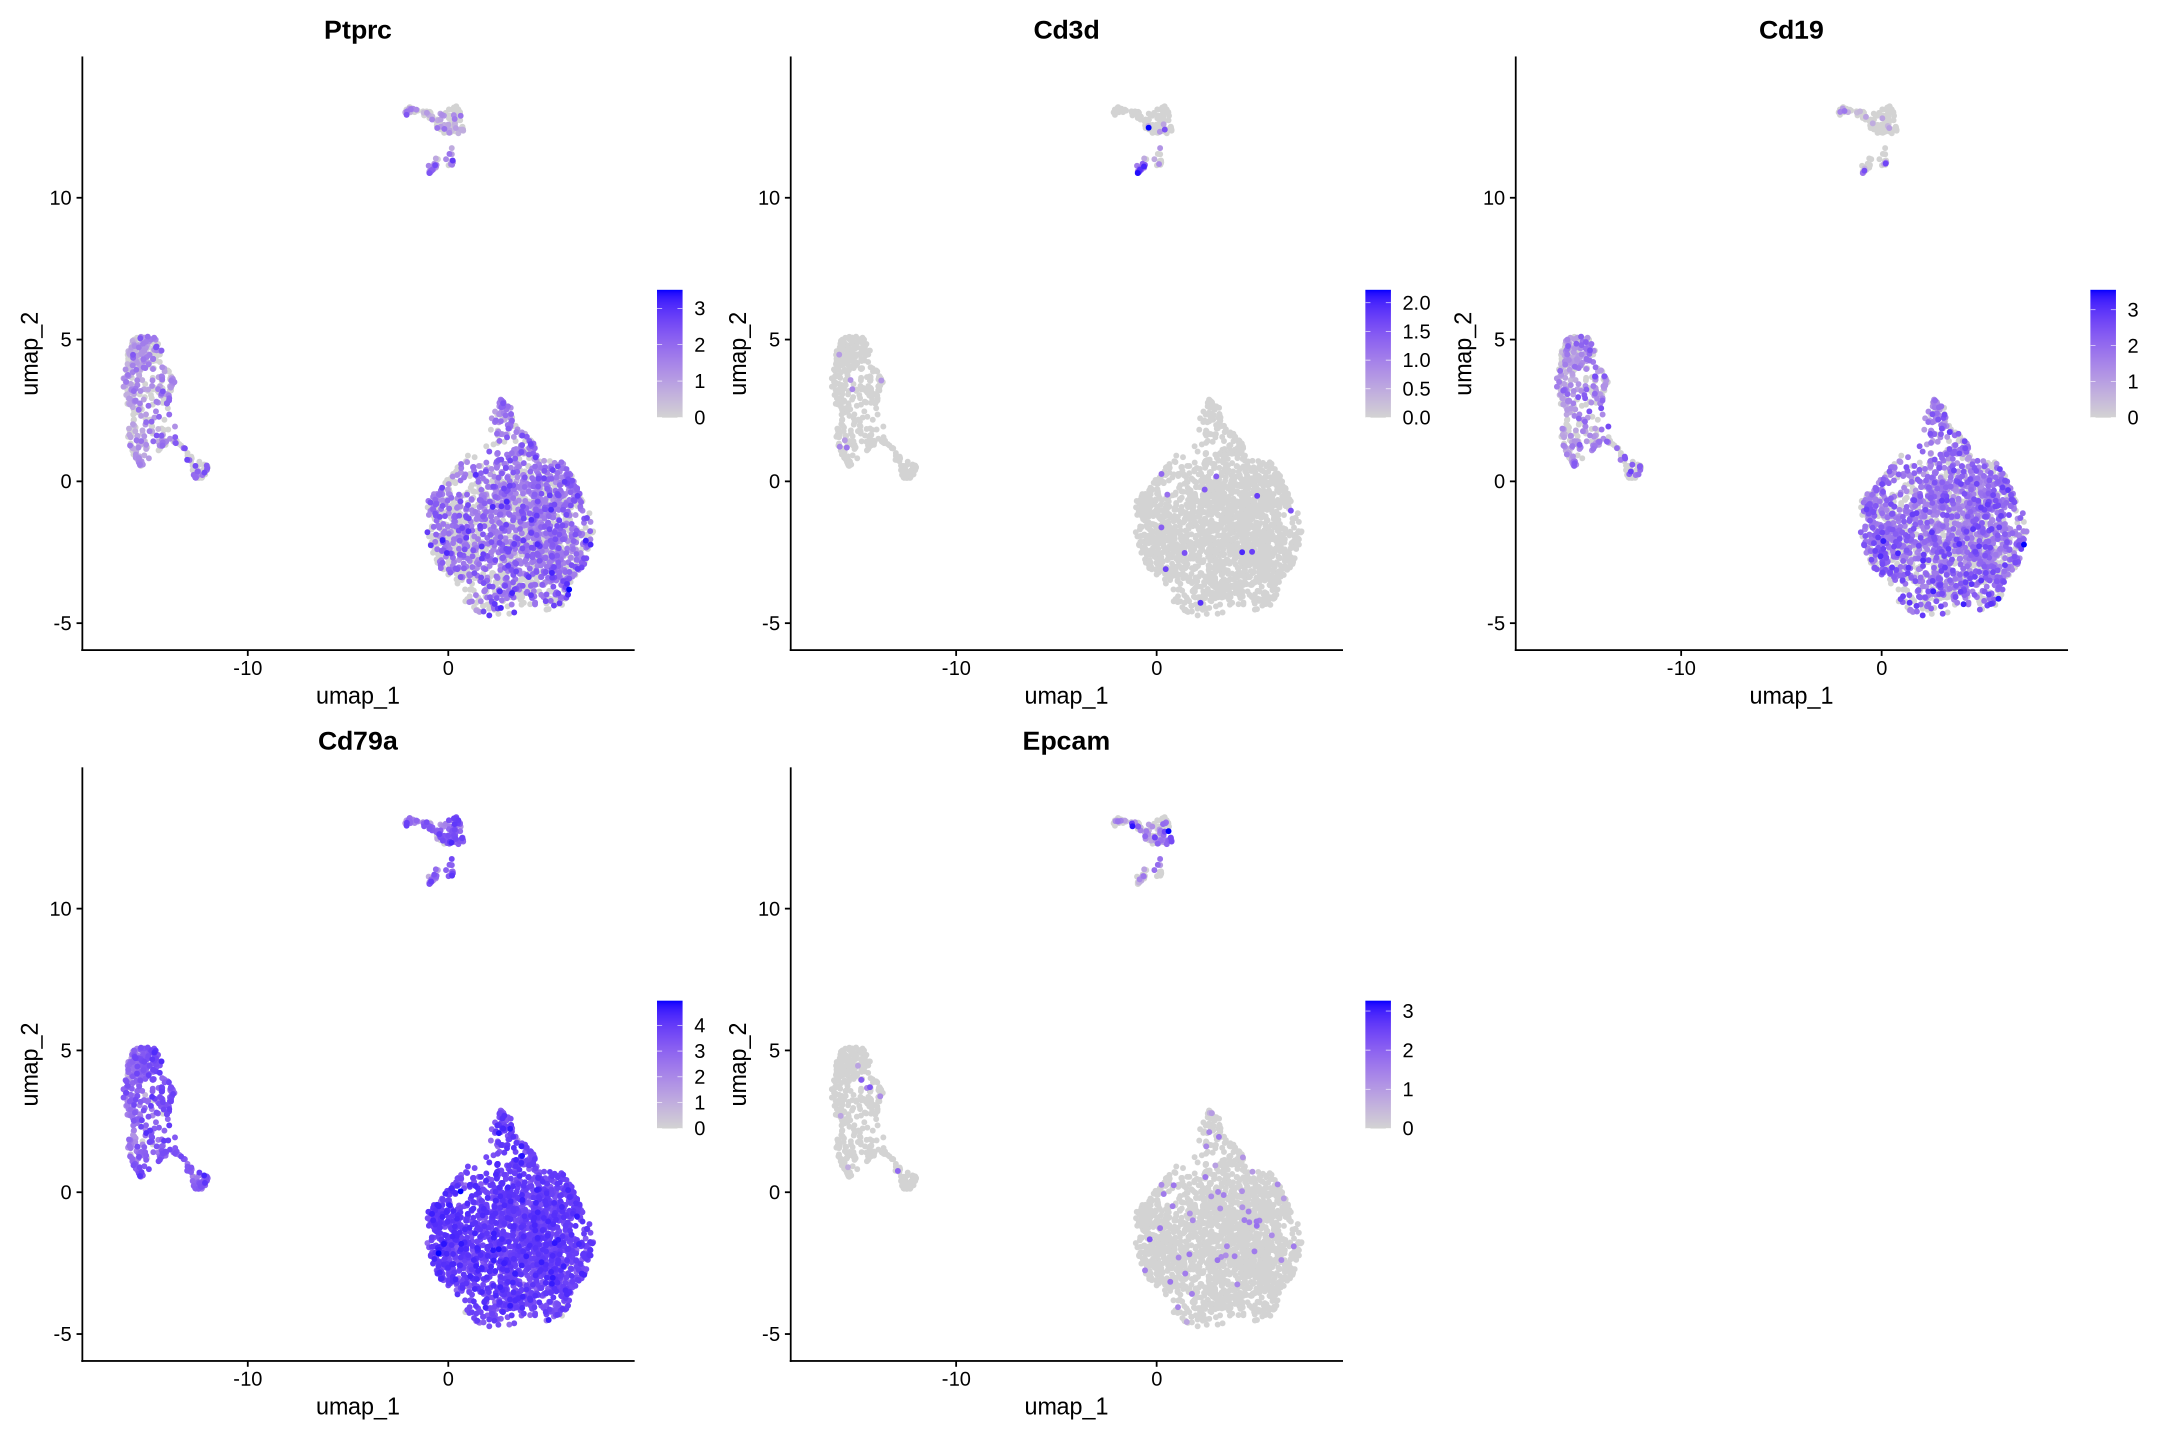

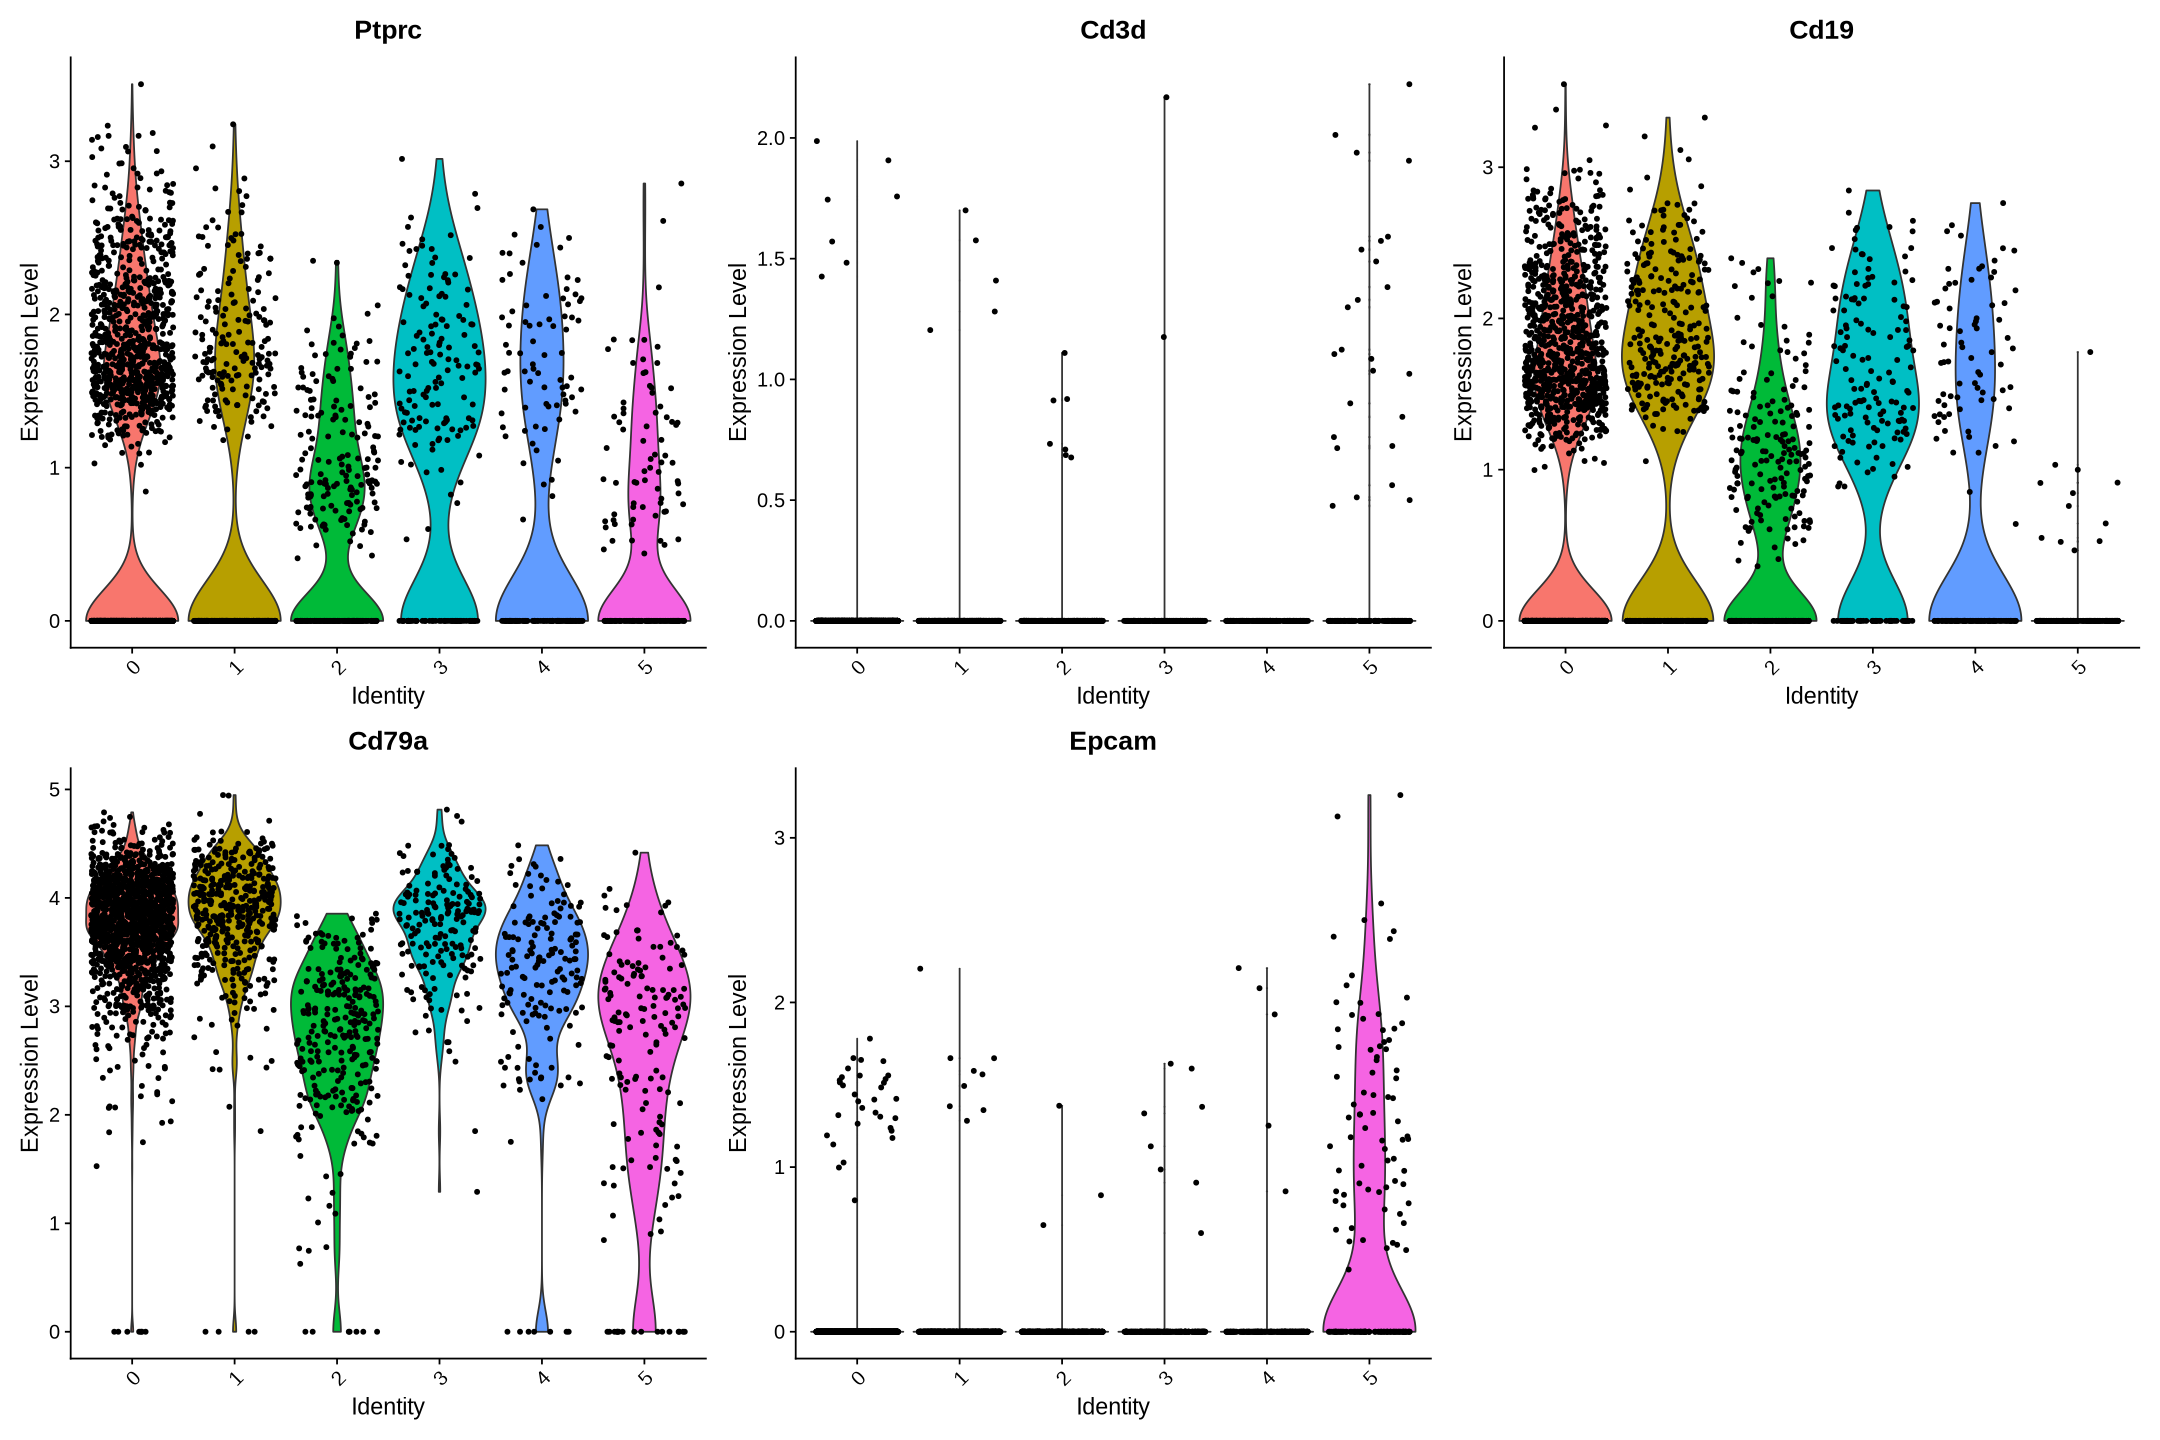

In [11]:
genes = filter(tbl_marker,sub_cell_type == 'cells')$gene
paste(genes,collapse = ',')
options(repr.plot.width = 6*3, repr.plot.height=6 * 1)
p_temp
ncol_ <- 3
nrow_ <- ifelse(length(genes) %% 3 == 0,
                floor(length(genes) %/% 3), floor(length(genes) %/% 3) + 1)
options(repr.plot.width = 6*ncol_, repr.plot.height=6 * nrow_)
p = FeaturePlot(adata, features = genes, ncol = 3,pt.size = 1,order = TRUE)
p
VlnPlot(adata,features = genes, ncol = 3,pt.size = 1)


In [12]:
filter(markers,gene %in% genes)

gene,cluster,avg_log2FC,pct.1,pct.2,p_val_adj
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>


In [ ]:
temp = '3' # q_cluster
genes <- (markers %>% filter(cluster == temp) %>% slice(1:12))$gene
# genes <-(tbl_marker %>% filter(cell_type == 'Neutro'))$gene
# genes = str_split('Adgre1,Itgam,Cd68,Cd14,Fcgr1,Csf1r', ',')[[1]]
paste(genes,collapse = ',')
# ncol_ <- 3
# nrow_ <- ifelse(length(genes) %% 3 == 0,
#                 floor(length(genes) %/% 3), floor(length(genes) %/% 3) + 1)
# options(repr.plot.width = 6*ncol_, repr.plot.height=6 * nrow_)
# p = FeaturePlot(adata, features = genes, ncol = 3,pt.size = 1,order = TRUE)
# p

# 提取UMAP坐标后，保存metadata

仅保存`cell_name,X_batch,status,cell_type,UMAP1,UMAP2,seurat_clusters,pre_cell_type`

存为`obs_Seurat.csv`

In [ ]:
# adata@meta.data %>% head(2)
df_umap = adata@reductions$umap@cell.embeddings %>% as.data.frame
df_umap = df_umap %>% mutate(
    cell_name = rownames(df_umap),.before=1
) %>% rename(UMAP1=umap_1,UMAP2=umap_2)
# df_umap %>% head(2)
adata@meta.data = seurat_metadata_leftjoin(
    adata@meta.data %>% select(cell_name,X_batch,status,cell_type,sub_cell_type,
                               seurat_clusters),
    df_umap,by=c('cell_name' = 'cell_name'),key_cell_name = 'cell_name'
)
adata@meta.data %>% head(2)
# # 防止重新运行时文件被覆盖
# adata@meta.data %>% 
#     rename(`_batch` = `X_batch`) %>%
#     write_csv(file.path(p_root_item,sprintf('obs_seurat_%s.csv',item)))
# cat(sprintf('[out] %s\n',file.path(p_root_item,sprintf('obs_seurat_%s.csv',item))))

In [ ]:
adata@meta.data %>% dim